In [248]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

import io
import PIL.Image, PIL.ImageDraw

import requests

import einops
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

# Notebook dependencies
from IPython.display import clear_output, Image

from original_utils import *

import importlib
import sys
importlib.reload(sys.modules['original_utils'])
from original_utils import *

device_id = 3
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

device is cuda:3


In [132]:
# Parameters

CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🛩"

USE_PATTERN_POOL = True # set in "persistent" mode

# Load target image
target_img = load_emoji(TARGET_EMOJI)

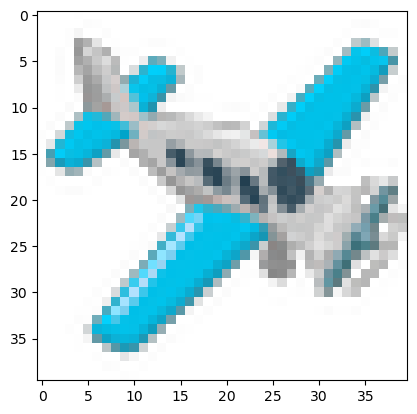

In [133]:
plt.imshow(target_img)
plt.show()

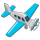

In [117]:
imshow(target_img)

In [41]:
# Define Model

class CAModel(nn.Module):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    conv1 = nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior
    # torch.nn.init.xavier_uniform_(conv1.weight) # default to how tensorflow initializes the weights
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )
    
  def perceive(self, x, angle=0.0):
    """Pytorch does convolutions differently. Reshape accordingly
      input is (batch, in_channels, H, W)
      kernel is (filter_height, filter_width, in_channels, channel_multiplier) in TF
      but should be (out_channels, in_channels / groups, H, W) in Torch"""
    identify = torch.as_tensor([0, 1, 0], dtype=torch.float32)
    identify = torch.outer(identify, identify)
    dx = torch.as_tensor(np.outer([1, 2, 1], [-1, 0, 1]) / 8.0, dtype=torch.float32) # Sobel filter
    dy = dx.T
    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    stacked_filters = torch.stack((identify, c*dx-s*dy, s*dx+c*dy)).to(device)
    kernel = torch.repeat_interleave(stacked_filters, self.channel_n, dim=0).view(self.channel_n*3, 1, 3, 3)
    y = F.conv2d(x, kernel, padding='same', groups=self.channel_n)
    return y

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle) # y should be on device
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
    x = x + dx * update_mask

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

CAModel().dmodel

Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)

seed shape is torch.Size([72, 72, 16])


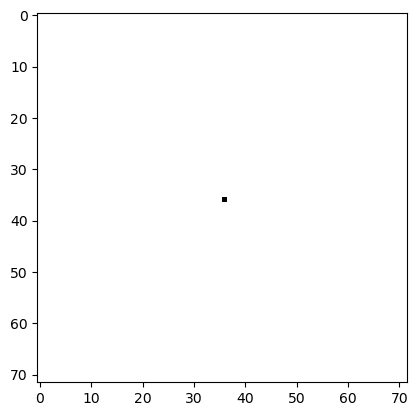

In [42]:
# Make training sample

p = TARGET_PADDING
target_img_tensor = torch.tensor(target_img)
pad_target = torch.nn.functional.pad(target_img_tensor, (0, 0, p, p, p, p))
h, w = pad_target.shape[:2]
seed = torch.zeros(h, w, CHANNEL_N, dtype=torch.float32)
seed[h//2, w//2, 3:] = 1.0
print(f'seed shape is {seed.shape}')

plt.imshow(seed[..., :4])
plt.show()

In [12]:
test_load = load_ca_model(CAModel, "vanilla_ca")

In [18]:
torch.cuda.current_device()
seed.get_device()

-1

In [47]:
x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
print(seed.shape)
print(x0.shape)
print(x0.dtype, seed.dtype)
print(x0.min(), x0.max(), seed.min(), seed.max())

torch.Size([72, 72, 16])
torch.Size([8, 72, 72, 16])
torch.float32 torch.float32
tensor(0.) tensor(1.) tensor(0.) tensor(1.)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 631.79it/s]


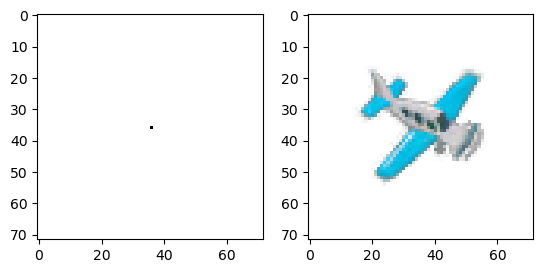

In [116]:
x = simulate_model(test_load, seed.unsqueeze(0), 85, device=device)

In [106]:
seed.shape

torch.Size([72, 72, 16])

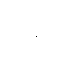

In [108]:
# plt.imshow(x_norm[0, ..., :4])
imshow(clip_tensor(x0)[0, ..., :4])

In [301]:
class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    # print(f"slot names: {self._slot_names}")
    # print(f"slot values: {list(slots.values())[0].shape}")
    # print(f"slot items: {slots.items()}")
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      # setattr(self, k, np.asarray(v))
      setattr(self, k, v)        

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

In [338]:
# Training Sequence

class Train:
  def __init__(self, ca_model, seed, target, lr=2e-3):
    """Initialize training object with model to train, seed and target
    
    :param ca_model: PyTorch model class object (instantiated)
    :param seed: PyTorch tensor of shape (H, W, C), initial seed to start training
    :param target: PyTorch tensor of shape (H, W, C), target image to learn
    """
    self.ca = ca_model
    self.seed = seed
    # Augment target tensor with batch dimension
    self.target = torch.repeat_interleave(target[None, ...], BATCH_SIZE, dim=0)
    self.lr = lr
    
    # Initialize optimizer with lr scheduler
    self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.optim, step_size=2000, gamma=0.1)    
    
    # Use library MSELoss
    self.loss_f = nn.MSELoss()
    
    # Pool of training samples for "persistent" training mode
    self.pool = SamplePool(x=np.repeat(self.seed.detach().cpu()[None, ...], POOL_SIZE, 0))

    # Log the training progress
    self.loss_log = []

  def train(self, n_steps=1001):
    """Train the model stored in `self.ca` for `n_steps` training steps

    :param n_steps: int, Number of training steps
    :return: list, loss history 
    """
    for i in range(n_steps):

      # Very similar to original TF implementation
      if USE_PATTERN_POOL:
        batch = self.pool.sample(BATCH_SIZE)
        x0 = batch.x.to(device)
        
        loss_rank = self._loss_f(x0, self.target).argsort(descending=True)
        # print(list(loss_rank))
        # print(list(loss_rank.detach().cpu().numpy()))
        x0 = x0[list(loss_rank.detach().cpu().numpy())]
        x0[:1] = seed # to prevent catastrophic forgetting
      else:
        x0 = torch.repeat_interleave(self.seed[None, ...], BATCH_SIZE, 0)
    
      # Run through a single training step of the model
      x, loss = self._train_step(x0)
      self.loss_log.append(loss)
      # print(f'loss log is {self.loss_log}')
    
      # Update pool
      if USE_PATTERN_POOL:
        batch.x[:] = x
        batch.commit()

      # Printing
      if i % 100 == 0:
        clear_output()

        # Visualize batch
        visualize_batch(x0.detach().cpu(), x.detach().cpu(), i)
        
        # Plot loss
        plot_loss(self.loss_log)
        
        # Export model
        # TODO

      print('\r step: %d, log10(loss): %.3f'%(len(self.loss_log), np.log10(loss)), end='')

    return self.loss_log
    
  def _train_step(self, x):
    """Perform the update step some random number of times"""
    iter_n = np.random.randint(64, 97, dtype=np.int32)
    # Clear previous gradients accumulated on parameters
    self.optim.zero_grad()
    for _ in range(iter_n):
      # Forward pass of model
      x = self.ca(x)

    # Compute loss
    # loss = self.loss_f(to_rgba(x), self.target)
    loss = self._loss_f(x, self.target).mean()

    # Compute gradients
    loss.backward()
    
    # Apply L2 normalization to parameter gradients as per original paper
    for p in self.ca.parameters():
      if p.grad is not None:
        p.grad /= p.grad.norm() + 1e-8 
        
    # Update parameters
    self.optim.step()
    
    # Update learning rate step
    self.scheduler.step()

    return x, loss.item()

  def _loss_f(self, output, target):
    return torch.square(to_rgba(output) - target).mean(dim=(-2, -3, -1))


In [343]:
USE_PATTERN_POOL=True

In [344]:
%%time
# original torch conv layer initialization WITH weight decay

ca = CAModel().to(device)
train = Train(ca, seed.to(device), pad_target.to(device))

loss_log = train.train(n_steps=4001)

[tensor(7, device='cuda:3'), tensor(6, device='cuda:3'), tensor(4, device='cuda:3'), tensor(5, device='cuda:3'), tensor(1, device='cuda:3'), tensor(0, device='cuda:3'), tensor(2, device='cuda:3'), tensor(3, device='cuda:3')]
[7, 6, 4, 5, 1, 0, 2, 3]


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB (GPU 3; 10.92 GiB total capacity; 279.26 MiB already allocated; 3.81 MiB free; 310.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

100%|███████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 495.85it/s]

batch (before/after):


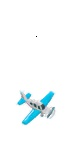

In [156]:
simulate_model(test_load, seed.unsqueeze(0), 80, device=device)

In [283]:
print(pad_target.shape)
test_out = torch.repeat_interleave(pad_target[None, ...], BATCH_SIZE, dim=0)
print(test_out.shape)
test_in = torch.randn(x0.shape)

##########################################

print(to_rgba(test_in).shape)
loss = nn.MSELoss()
loss1 = loss(to_rgba(test_in)[-1, ...], pad_target)
loss2 = loss(to_rgba(test_in), test_out)

print(loss1, loss2)

##########################################

batched_loss = torch.square(to_rgba(test_in) - test_out).mean(dim=(-2, -3, -1))
print(batched_loss)
print(batched_loss.mean())
print(batched_loss.numpy().argsort())
loss_rank = batched_loss.numpy().argsort()[::-1]
print(loss_rank, type(loss_rank))

print(type(x0), type(batch.x))
x0_test = batch.x[loss_rank]
print(x0_test.shape)

x0_test2 = x0[list(loss_rank)]
print(x0_test2.shape)

########################################

x=np.repeat(seed[None, ...], POOL_SIZE, 0)
print(x.shape)

#########################################

pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
for k in pool._slot_names:
    print(k)
    v = getattr(pool, k)
    print(v.shape, type(v))
getattr(pool, '_parent')
batch = pool.sample(BATCH_SIZE)

print()
for k in pool._slot_names:
    print(k)
    v = getattr(pool, k)
    print(v.shape, type(v))
    
################################################

print(batch.x.shape, type(batch.x))
print(x0.shape, type(x0))
np.allclose(batch.x, x0)

torch.Size([72, 72, 4])
torch.Size([8, 72, 72, 4])
torch.Size([8, 72, 72, 4])
tensor(1.0531) tensor(1.0620)
tensor([1.0804, 1.0659, 1.0561, 1.0623, 1.0600, 1.0561, 1.0622, 1.0531])
tensor(1.0620)
[7 2 5 4 6 3 1 0]
[0 1 3 6 4 5 2 7] <class 'numpy.ndarray'>
<class 'torch.Tensor'> <class 'numpy.ndarray'>
(8, 72, 72, 16)
torch.Size([8, 72, 72, 16])
torch.Size([1024, 72, 72, 16])
slot names: dict_keys(['x'])
slot values: torch.Size([1024, 72, 72, 16])
x
(1024, 72, 72, 16) <class 'numpy.ndarray'>
slot names: dict_keys(['x'])
slot values: (8, 72, 72, 16)

x
(1024, 72, 72, 16) <class 'numpy.ndarray'>
(8, 72, 72, 16) <class 'numpy.ndarray'>
torch.Size([8, 72, 72, 16]) <class 'torch.Tensor'>


True